170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 112s 283ms/step - loss: 0.0165 - val_loss: 0.0058
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 135s 266ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 143s 268ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 146s 278ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 140s 273ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 149s 290ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 134s 270ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 143s 273ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 272ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 143s 274ms/step - loss: 0.0039 - val_loss: 0.0039
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Aver

<ipython-input-1-7cf5a92da551>:51: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_values = [psnr(x_test_gray[i], restored_images[i]) for i in range(10)]


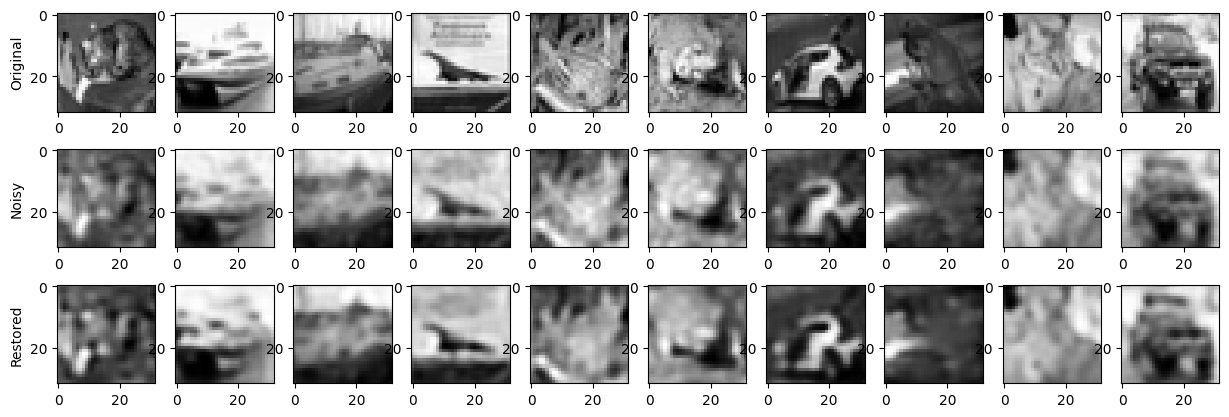

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load and preprocess data
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize between 0-1

# Convert to grayscale
x_train_gray = np.mean(x_train, axis=-1, keepdims=True)
x_test_gray = np.mean(x_test, axis=-1, keepdims=True)

# Introduce noise and blur
def degrade_image(img):
    noisy_img = img + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=img.shape)  # Gaussian noise
    noisy_img = np.clip(noisy_img, 0, 1)
    blurred_img = cv2.GaussianBlur(noisy_img, (5, 5), 1)  # Apply Gaussian blur
    return blurred_img

x_train_noisy = np.array([degrade_image(img) for img in x_train_gray])
x_test_noisy = np.array([degrade_image(img) for img in x_test_gray])

# Build the Autoencoder
input_img = Input(shape=(32, 32, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train the model
autoencoder.fit(x_train_noisy, x_train_gray, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test_gray))

# Image restoration and evaluation
restored_images = autoencoder.predict(x_test_noisy)

# Compute PSNR
psnr_values = [psnr(x_test_gray[i], restored_images[i]) for i in range(10)]
print(f"Average PSNR: {np.mean(psnr_values)}")

# Display results
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axes[0, i].imshow(x_test_gray[i].squeeze(), cmap='gray')
    axes[1, i].imshow(x_test_noisy[i].squeeze(), cmap='gray')
    axes[2, i].imshow(restored_images[i].squeeze(), cmap='gray')

axes[0, 0].set_ylabel("Original")
axes[1, 0].set_ylabel("Noisy")
axes[2, 0].set_ylabel("Restored")
plt.show()


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

# Load VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = Flatten()(base_model_vgg.output)
x = Dense(512, activation='relu')(x)
output_vgg = Dense(100, activation='softmax')(x)
vgg16_model = Model(inputs=base_model_vgg.input, outputs=output_vgg)

# Load AlexNet Model (Approximated using MobileNetV2)
base_model_alex = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = Flatten()(base_model_alex.output)
x = Dense(512, activation='relu')(x)
output_alex = Dense(100, activation='softmax')(x)
alexnet_model = Model(inputs=base_model_alex.input, outputs=output_alex)

# Compile models
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train models (use fewer epochs for testing)
vgg16_model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))
alexnet_model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

# Evaluate performance
vgg16_score = vgg16_model.evaluate(x_test, y_test, verbose=0)
alexnet_score = alexnet_model.evaluate(x_test, y_test, verbose=0)

print(f"VGG16 Test Accuracy: {vgg16_score[1] * 100:.2f}%")
print(f"AlexNet (MobileNetV2) Test Accuracy: {alexnet_score[1] * 100:.2f}%")


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-1-e890bf58060f>:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_alex = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 61s 113ms/step - accuracy: 0.0088 - loss: 4.6138 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 72ms/step - accuracy: 0.0092 - loss: 4.6054 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.0091 - loss: 4.6054 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.0098 - loss: 4.6054 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.0091 - loss: 4.6054 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - accuracy: 0.1361 - loss: 3.8731 - val_accuracy: 0.0373 - val_loss: 7.5930
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.3616 - loss: 2.4248 - val_accuracy: 0.0577 - val_loss: 7.0488
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms